# Analysis of Cointegrated Processes
## With an application to treasury yield rates of different maturities

The code in this Jupyter notebook was written using Python 3.7.4. It also uses four data files that can be downloaded from the [official website of the US Treasury Department](https://home.treasury.gov/data/treasury-coupon-issues-and-corporate-bond-yield-curves/treasury-coupon-issues
). The data files and Jupyter notebook file InterestRateApplication.ipynb are stored along with graphs of the analysis in the public GitHub repository https://github.com/AlbertSteen314/Python-Projects/tree/master/Cointegration.

The goal of this project was to learn more about the theory of multivariate time series econometrics and apply these tools to a real world problem. In particular I focus on the modelling and forecasting of non-stationary time series. I imitate broadly the approach taken in Bradley and Lumpkin (1992). I examine the relationship between the 6 month, 1 year, 3 year, 5 year, 7 year, 10 year and 30 year Treasury bond rate using data from 2003 till now. I will test whether there is evidence that these series are cointegrated, estimate a variety of models and compare their forecast performance.

# 1. Brief History

Many (macro)economic processes are integrated; i.e. they contain a unit root and have to be differenced before they are stationary (first and second moments dont change over time). Newbold and Granger (1974) showed that linear regression of non-stationary time series could produce spurious relationships. For example, two series that are not causally related, could show a strong association ($R^2$) through their common connection with a third variable. In some cases however, multiple integrated time series are said to be cointegrated. This concept was introduced in a series of papers by Granger (1983), Granger and Weiss (1983) and Engle and Granger (1987). In this case a linear combination of the seres $\beta'x_t$ can be thought of as a long run equilibrium and the deviations from this equilibrium _is_ a stationary process. 

Whether variables are cointegrated or not is typically deduced from economic theory. In this project I analyse interest rates of government bonds of different maturities. The "unbiased expectations hypothesis", loosely speaking, states that the expected return of bonds of different maturities is equal. It enables us to link bond prices of different maturities and allows us to price them such that there are no arbitrage opportunities. This is important for forecasting economic conditions, setting monetary policy, price bonds and hedging. 

# 2 The Model
## 2.1 Representation

Vector autoregressions (VAR) are the workhorse models for analysing systems of time series. This model was introduced by Sims (1980). My main source of reference is Lutkepohls "New Introduction to Multiple Time Series Analysis" (2005) and I will follow the notation from the book, primarily on p.13, p.25, p.70 and p.286 notational details are outlined. A basic stationary VAR(p) model takes on the form: 

$$y_{t} = c + A_1 y_{t-1} + ... + A_p y_{t-p} + u_t $$ 

where $y_t = (y_{1,t},...,y_{k,t})'$ is a kx1 vector of endogenous variables, $c$ a kx1 vector of intercept terms, $A_i$ a kxk coefficient matrix and $u_t = (u_{1,t},...,u_{k,t})$ is a kx1 white noise process with covariance matrix $\Sigma_u$. Additionaly, any VAR(p) can be represented as a VAR(1) (called compact form, companion form, or stacked form) like 

\begin{equation} Y_{t} = \pmb c + A Y_{t-1}+ U_t \label{eq:special} \tag{1} \end{equation}

VARs can describe relationships between stationary variables. When we deal with non-stationary data, we typically difference them in order to make them stationary, so we can then still estimate a VAR (on the differenced data) and uncover the relations we are interested in. However, when we deal with cointegrated systems, differencing a VAR specification is problematic, because it discounts potentially long run equilibrium trends. A better specification would be the vector error correction model (VECM), which is another representation of a VAR(p) in the case of cointegrated variables:  

\begin{align} \Delta y_t = v + \Pi y_{t-1} + \Gamma_1 \Delta y_{t-1} + ...+ \Gamma_{p-1} \Delta y_{t-p+1} + u_t \tag{2}\\ 
\Pi = \alpha \beta ' \\ 
\alpha_i \beta_i ' y_{i,t-1} = \alpha_i (b_{i,1} y_{1,t-1} + ... + b_{i,k} y_{k,t-1})\end{align}

In (2) the term associated with $\Pi$ directly encapsulates the "out of equilibrium" effects. In the literature it is not clear what is the most efficient estimation procedure when dealing with cointegrated systems. I will compare an unrestricted VAR in levels, a VAR in differences, and a VECM.

## 2.2 Estimation Procedure

1. Test the order of integration of each your time series using the dickey fuller and kpss test.
2. Decide on lag order of the VECM. If the optimal VAR(p) order is p*, the lag order of the corresponding VECM model is (p*-1). To find the optimal lag order of the VAR model minimize the Akaikes information criterion (AIC) of the VAR in levels for different values of p. The AIC penalizes the number or parameters, which in a VAR grows exponentially as p grows, and favors the optimal likelihood value.
3. Test for the rank r of $\Pi$, r is the number of cointegrating relations (there can be more than 1). This is done using the trace and maximum eigenvalue test on the residual product matrix of $\Delta Y_t$ and $Y_{t-1}$ corrected for the effects of other regressors. 
4. Given r, obtain an estimate of $\beta$ and renormalize, since it is not unique.
5. Given r and $\beta$ estimate remaining parameters either by maximum likelihood or OLS.
6. Transform parameters to their VAR counterpart.

## 2.3 Advantages and Limitations
(+)
- VAR models are flexible, rich structure that can capture many features of the data.
- Since all variables are endogenous and no restrictions have to imposed. This is an advantage over simultaneous equations models that can only be estimated when some variables are treated as exogenous and when they have different RHS variables. VAR models require less restricting assumptions. 
- Allows learning about dynamic interrelationships between a number of variables (structural analysis).
- Good model for forecasting.

(-)
- A lot of coefficients have to be estimated.
- Hard to interpret coefficients.
- A-theoretical, can result in spurious relations.
- Requires stationary series, many series are not stationary and differencing the data throws away a lot of information.

# 3. Building the Model

In [52]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.vector_ar import util
import scipy
from scipy.linalg import fractional_matrix_power
import scipy.stats as stats

# import and prep data
path1 = '/Users/ezravanderstelt/Desktop/python/ectri/cointegration/data/tnc_03_07.xls'
path2 = '/Users/ezravanderstelt/Desktop/python/ectri/cointegration/data/tnc_08_12.xls'
path3 = '/Users/ezravanderstelt/Desktop/python/ectri/cointegration/data/tnc_13_17.xls'
path4 = '/Users/ezravanderstelt/Desktop/python/ectri/cointegration/data/tnc_18_22.xls'

data1 = pd.read_excel(path1, skiprows = [0,1,2], usecols = 'A,C:BJ').T
data2 = pd.read_excel(path2, skiprows = [0,1,2], usecols = 'A,C:BJ').T
data3 = pd.read_excel(path3, skiprows = [0,1,2], usecols = 'A,C:BJ').T
data4 = pd.read_excel(path4, skiprows = [0,1,2], usecols = 'A,C:BJ').T

data = [data1, data2, data3, data4]
for d in data:
    d.columns = d.iloc[0]
    
data1 = data1.drop(data1.columns[1], axis=1)[1:]
data2 = data2.drop(data2.columns[1], axis=1)[1:]
data3 = data3.drop(data3.columns[1], axis=1)[1:]
data4 = data4.drop(data4.columns[1], axis=1)[1:33]

merged = pd.concat([data1,data2,data3], axis=0) 
time = pd.date_range('2003-01-01 10:15', periods = 180, freq = 'M')
data = merged.set_index(time).drop('Maturity', axis=1)
time_out = pd.date_range('2018-01-01 10:15', periods = 32, freq = 'M')
data_out = data4.set_index(time_out).drop('Maturity', axis=1)

cols = [0.5,1,3,5,7,10,30]
data = data[cols]
data_out = data_out[cols]
print(data.head(3))

del data1, data2, data3, data4, d, path1, path2, path3, path4, merged

Unnamed: 0            0.5     1     3     5     7    10    30
2003-01-31 10:15:00  1.04  1.29  2.26   3.1  3.77  4.46  5.32
2003-02-28 10:15:00  1.01  1.22  2.12  2.96  3.61  4.29   5.2
2003-03-31 10:15:00  1.01   1.2  2.04  2.85   3.5  4.18   5.2


False
0


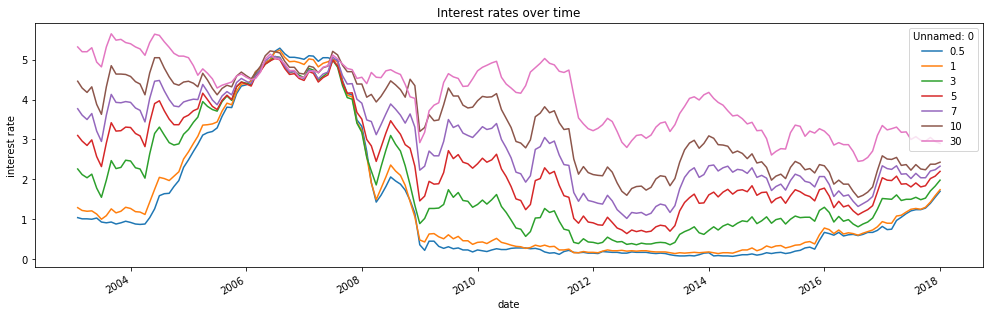

In [53]:
# balanced panel? make plot of timeseries
print(data.isnull().values.any())
print(data.isnull().sum().sum())

data.plot(title='Interest rates over time', figsize=(17,5)).set(xlabel="date", ylabel="interest rate")
plt.savefig(fname='/Users/ezravanderstelt/Desktop/python/ectri/cointegration/graphs/interestrates.png')

In [54]:
# check order of integration 
import warnings
warnings.simplefilter('ignore', category=UserWarning)
for col in cols:
    serie = data[col]
    adf_p = adfuller(serie)[1]
    kpss_p = kpss(serie, nlags = 'auto')[1]
    if adf_p>0.05:
        print('Series of %s' %(col) + ' has a unit root according to adf')
    else:
        print('Series of %s' %(col) + ' has no unit root according to adf')
    if kpss_p>0.05:
        print('Series of %s' %(col) + ' has no unit root according to kpss')
    else:
        print('Series of %s' %(col) + ' has a unit root according to kpss')

diff = data.diff()[1:]        
for col in cols:
    serie = diff[col]
    adf_p = adfuller(serie)[1]
    kpss_p = kpss(serie, nlags = 'auto')[1]
    if adf_p>0.05:
        print('Differenced series of %s' %(col) + 'has a unit root according to adf')
    else:
        print('Differenced series of %s' %(col) + 'has no unit root according to adf')
    if kpss_p>0.05:
        print('Differenced series of %s' %(col) + 'has no unit root according to kpss')
    else:
        print('Differenced series of %s' %(col) + 'has a unit root according to kpss')

del adf_p, col, diff, kpss_p, serie

Series of 0.5 has a unit root according to adf
Series of 0.5 has a unit root according to kpss
Series of 1 has a unit root according to adf
Series of 1 has a unit root according to kpss
Series of 3 has a unit root according to adf
Series of 3 has a unit root according to kpss
Series of 5 has a unit root according to adf
Series of 5 has a unit root according to kpss
Series of 7 has a unit root according to adf
Series of 7 has a unit root according to kpss
Series of 10 has a unit root according to adf
Series of 10 has a unit root according to kpss
Series of 30 has a unit root according to adf
Series of 30 has a unit root according to kpss
Differenced series of 0.5has no unit root according to adf
Differenced series of 0.5has no unit root according to kpss
Differenced series of 1has no unit root according to adf
Differenced series of 1has no unit root according to kpss
Differenced series of 3has no unit root according to adf
Differenced series of 3has no unit root according to kpss
Differ

Both the kpss and adf test imply $y\sim I(1)$. Make functions that transform the data in stacked form for estimation and prepare lag order selection function. Again, I refer to Lutkepohl (2005) for details. 

In [55]:
def YZ_VAR_MATRIX(data, p):
    """
    Takes in dataframe data and VAR order p. Returns (p*k+1)x(T) stacked Z and Y array; Y=BZ+U. Lutk p.70
    """
    Y = np.array(data[p:].T.values.astype('float64'))
    
    T = data.shape[0]-p
    Z = []
    for i in range(T):
        z = [[1]]
        col = data.iloc[i:i+p,:].values[::-1].flatten().tolist()
        z.append(col)
        flat_z = [item for sublist in z for item in sublist]
        Z.append(flat_z)
    Zarray = np.array(Z).T
    return Y, Zarray

def dYX_VECM_MATRIX(data, p):
    """
    This function returns the VECM matrices for estimation, 
    (p*k+1)x(T-p) stacked dX VAR matrix and dY matrix. Lutk p.286
    """
    d=data.diff()
    dY = np.array(d[p:].T.values.astype('float64'))
    
    T = data.shape[0]-p
    Z = []
    for i in range(T):
        z = [[1]]
        col = d.iloc[i+1:i+p,:].values[::-1].flatten().tolist()
        z.append(col)
        flat_z = [item for sublist in z for item in sublist]
        Z.append(flat_z)
    dX = np.array(Z).T
    return dY, dX

def AIC(data, max_p):
    """
    Sequentially estimate VARs till VAR(p), record akaike information criteria estimator (AIC)
    """
    lags = [p for p in range(max_p+1)]
    aic_full = pd.DataFrame(np.zeros(len(lags)), index =lags ,dtype=float)
    k=data.shape[1]

    for i,p in enumerate(lags):
        Y,Z = YZ_VAR_MATRIX(data = data, p=p)
        B = (Y@Z.T)@(np.linalg.inv(Z@Z.T))    
        U = Y-B@Z
        T = 180-p
        params = p*(k**2)
        sigma = 1/T*(U@U.T)
        AIC = np.log(np.linalg.det(sigma))+(2/T)*params
        aic_full.iloc[i,0] = AIC
    return aic_full

In [56]:
# determine lag order p, dont consider p>5, this would already be more than 5*7*7=245 parameters!
aic = AIC(data, max_p = 5)
aic

,0
0,-32.416076
1,-46.056618
2,-46.305276
3,-46.371787
4,-46.275086
5,-46.187308


In [57]:
# apply Johansen procedure and estimate VECM(2)
p = 3
k = data.shape[1]
T = data.shape[0]-p

Y,Z = YZ_VAR_MATRIX(data = data, p=p)    
Ylag = Z[1:k+1,:].copy()
dY, dX = dYX_VECM_MATRIX(data= data, p=p)

# annihilator matrix to take out short run effects
M = np.eye(T) - dX.T@(np.linalg.inv(dX@dX.T))@dX
R0 = dY@M
R1 = Ylag@M

S11 = (1/T)*R1@R1.T
S10 = (1/T)*R1@R0.T
S00 = (1/T)*R0@R0.T
S01 = (1/T)*R0@R1.T

SS = fractional_matrix_power(S11, -0.5)@S10@fractional_matrix_power(S00, -1)@S01@fractional_matrix_power(S11, -0.5)
lambdas, eigvec = np.linalg.eig(SS)

# sort from high to low
idx = lambdas.argsort()[::-1]
lambdas = lambdas[idx]
eigvec = eigvec[:,idx]

In [59]:
# determine r by sequentially running trace and maximum eigenvalue tests, r=2
from statsmodels.tsa.coint_tables import c_sja, c_sjt
LRtrace = -T*(sum(np.log(1-lambdas)))
LRmax = -T*(np.log(1-lambdas)[0])
print(LRtrace > c_sjt(7,0))
print(LRmax > c_sja(7,0))

LRtrace = -T*(sum(np.log(1-lambdas[1:])))
LRmax = -T*(np.log(1-lambdas[1]))
print(LRtrace > c_sjt(6,0))
print(LRmax > c_sja(6,0))

LRtrace = -T*(sum(np.log(1-lambdas[2:]))) 
LRmax = -T*(np.log(1-lambdas[2]))
print(LRtrace > c_sjt(5,0))
print(LRmax > c_sja(5,0))

[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[False False False]
[False False False]


In [60]:
# get ML estimators as in Lutk p.295 and use identification strategy of p.296 remark3
r=2
b = fractional_matrix_power(S11, -0.5)@eigvec[:,:r]
Ir = np.eye(r)
b_r = b[:r]
b_kr = (b@np.linalg.inv(b_r))[r:]
b_norm = np.vstack([Ir,b_kr])
a_norm = S01@b_norm@np.linalg.inv(b_norm.T@S11@b_norm)
ab = a_norm@b_norm.T

gamma =(dY-ab@Ylag)@dX.T@np.linalg.inv(dX@dX.T)
V=gamma[:,0]
gamma1=gamma[:,1:k+1]
gamma2=gamma[:,k+1:]
dYhat = ab@Ylag + gamma@dX
Uhat = dY - dYhat
Su = (1/T)*(Uhat@Uhat.T)
unbiased_Su = T/(T - 1- k*p)*(Su)

del LRtrace, LRmax, idx ,b,b_r,b_kr, Ir, SS, M, R0, R1, S00, S01, S10, S11

In [61]:
# VAR representation of VECM parameters
A1_rep = ab+np.eye(k)+gamma1
A2_rep = gamma2-gamma1
A3_rep = -gamma2
V_rep = V.copy()
coefs = [V_rep, A1_rep, A2_rep, A3_rep]

Now that the model parameters are estimated, we should test to what extent the error assumptions are satisfied. I will apply the Portmanteau and Jarque-Bera test for serial correlation and normality of residuals. 
* The statsmodels source code helped me a lot for coding this part, some parts are mimicked

In [62]:
def ACF(Uhat, lags=1):
# Uhat is a kxT array
    result = []
    for h in range(0,lags+1):
        if h==0:
            covh=Uhat@Uhat.T
            result.append(covh)
        else:
            covh = (Uhat[:,h:]@Uhat[:,:-h].T)
            result.append(covh)
    
    return np.hstack(result)/Uhat.shape[1]

def PortmanteauStatistic(Uhat, lags=1):
# test whether any of the autocorrelations up to till 'lags' is significant, Lutk p.169
    k=Uhat.shape[0]
    T=Uhat.shape[1]
    acf = ACF(Uhat = Uhat, lags = lags)
    C0_inv = np.linalg.inv(acf[:,0:k])
    Q=0
    for h in range(1,lags+1):
        Ci = acf[:,k*h:k*(h+1)]
        score = np.trace(Ci@C0_inv@Ci.T@C0_inv)
        Q+=score
    Q*=T
    
    return Q

def Normality(Uhat):
# jarque-bera test for normality, returns t-stat based on 3rd and 4th moment values, Lutk p.175
    T=Uhat.shape[1]
    Ucentered = Uhat.T-np.mean(Uhat.T, axis=0)
    Scentered = Ucentered.T@Ucentered/T
    Pinv = np.linalg.inv(np.linalg.cholesky(Scentered))
    w = Pinv@Ucentered.T

    b1 = (w**3).sum(1) [:, None] / T
    b2 = (w**4).sum(1)[:, None] / T - 3
    lam_skew = (T/6) * (b1.T@b1)
    lam_kurt = (T/24) * (b2.T@b2)

    return float(lam_skew + lam_kurt)

There is no evidence of serial correlation
Evidence of non-normal residuals


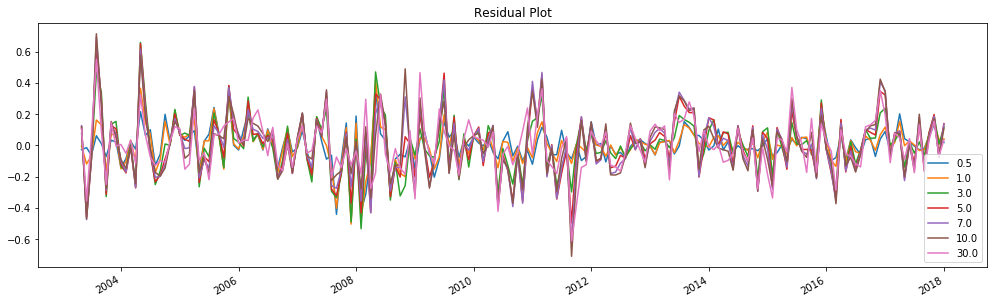

In [63]:
# Diagnostics
Q = PortmanteauStatistic(Uhat=Uhat, lags=1)
df = p*k**2-k**2*(p-1)-k*r
dist = stats.chi2(df)
cv = dist.ppf(1-0.05)
if Q>cv:
    print('No evidence of no serial correlation')
else:
    print('There is no evidence of serial correlation')

lambda_joint_stat = Normality(Uhat)
joint_dist = stats.chi2(k * 2)
joint_cv = joint_dist.ppf(1 - 0.05)

if lambda_joint_stat>joint_cv:
    print('Evidence of non-normal residuals')
else:
    print('Evidence of normally distributed residuals')
    
pd.DataFrame(Uhat.T, index=time[p:], columns = cols).plot(figsize=(17,5), title='Residual Plot')

## 4. Forecasting Performance

In this section I will compare the relative performance of different models. A wrong model might be better for forecasts if the 'correct' model is estimated with a lot of uncertainty. In this case you introduce bias to increase forecast accuracy. So it is not obvious that restricted VARs neccesarily outperform unrestricted VARs that ignore long term effects (Clements/Hendry 1995, Christoffersen/Diebold 1997, Hoffman/Rasche 1996).

The evaluation metrics are the MSFE, MAFE, and 'sign'. The 'sign' metric represents the fraction of forecasts that correctly predicted whether the next period would increase or decline in value. The models are estimated using data from 2003-2018 and will forecast the short term interest rate from january 2018 to august 2020 (32 points). It will be a "rolling forecast", in the sense that after each 1 step ahead forecast, the actual realisation is used in the next 1 step ahead forecast. The long horizon forecasts (not rolling) are judged based on MSFE and MSFA.
For multivariate error measures use TMSFE which is sum of individual MSFE of each variable.

I will contrast the forecast performance of three different specification following the previously mentioned literature. I will compare a VECM(2), an unrestricted VAR(3) (UVAR), and a VAR(3) in differences (DVAR). Hoffman/Rasche find that at long horizons the VECM outperforms the other models, Clements/Hendry find that performance is not robust across evaluation metrics. Also they stress the importance of correctly identifying the order of cointegration over de order of integration. Christoffersen/Diebold find the opposite, costs of incorrectly recognizing the order of integration are greater than the costs of incorrectly restricting the cointegration space. 

In [64]:
def ForecastVAR(yt, p, coefs, h=5):
    # return 1,..,h step ahead forecasts of VAR(p) defined by coefs=[C:A1:..:Ap], yt is p initial forecast values 
    k = yt.shape[1]
    pred = np.vstack([yt ,np.zeros((h,k))])
    for i in range(p,p+h):
        c = coefs[0].T
        A = np.zeros(k)
        for l in range(1,p+1):
            A= A + coefs[l]@pred[i-l].T
        yhat = c+A
        pred[i]=yhat
        
    return pred[p:]

def MA_Phi(coefs, p, h):
    """
    Use alternative computation Phi, slide40 ectr2 part1 2016 slides or Lutk p.23 
    equation 2.1.22. Code from statsmodels ma_rep(). coefs array
    """
    k = coefs.shape[1]
    coefs = coefs.reshape((p,k,k))
    phis = np.zeros((h, k, k))
    phis[0] = np.eye(k)
    for i in range(1, h):
        for j in range(1, i+1):
            if j > p:
            # if j>i: ??
                break

            phis[i] += np.dot(phis[i-j], coefs[j-1])
    
    return phis

def ConfidenceInterval(pred, coefs, sigma, alpha=0.05):
    """
    Assume gaussian errors, make confidence bounds for pred, sigma is uncorrected residual variance.
    slides 97/98 ectr2 and chapter 2.2.3 Lutk p.39 and statsmodels
    returns lower,upper confidence bounds
    """
    k=pred.shape[1]
    h= pred.shape[0]
    A = np.concatenate(coefs[1:], axis=0)
    phis = MA_Phi(coefs = A, p=(len(coefs)-1), h= h)
    mse = np.zeros((h, k, k))
    prior = np.zeros((k, k))
    for h_index in range(h):
        # Sigma(h) = Sigma(h-1) + Phi Sig_u Phi'
        phi = phis[h_index]
        var = phi @ sigma @ phi.T
        mse[h_index] = prior = prior + var
    
    q = util.norm_signif_level(alpha)
    lower = np.zeros((h, k))
    upper = np.zeros((h, k))
    for h_index in range(h):
        sd = np.sqrt(np.diag(mse[h_index]))
        lower[h_index] = pred[h_index] - q*sd
        upper[h_index] = pred[h_index] + q*sd    
    
    return lower, upper
        
def RollingOneStepForecast(yt, future, p, coefs, sigma, h=5, col = 0):
    """
    return array with lowerbound, prediction, and upperbound. inputs yt are prior values for forecast, 
    future are realisations, col is the column index of interest
    """  
    k = yt.shape[1]
    rolling_lower = np.zeros((h,k))
    rolling_upper = np.zeros((h,k))
    rolling_pred = np.zeros((h,k))
    dat = np.vstack([yt,future[:h]])
    for i in range(h):
        pred = ForecastVAR(yt=dat[i:i+p], p=p, coefs=coefs, h=1)    
        l,h= ConfidenceInterval(pred= pred, coefs=coefs, sigma=Su, alpha=.05)
        rolling_pred[i] = pred
        rolling_lower[i] = l
        rolling_upper[i] = h
    roll = np.column_stack([rolling_lower[:,col], rolling_pred[:,col], rolling_upper[:,col]]).astype(float)
    
    return roll

In [65]:
# forecast VECM(2) and gauge performance
h=data_out.shape[0]
cols_fc = ['low','fc','top','real']
rolling_forecast_performance = pd.DataFrame(data= np.zeros((3,3)), index=['UVAR3','DVAR3','VECM2'],
                                    columns = ['MSFE','MAFE','Sign'])
forecast_performance = pd.DataFrame(data= np.zeros((3,2)), index=['UVAR3','DVAR3','VECM2'],
                                    columns = ['MSFE','MAFE'])

rolling_fc3 = RollingOneStepForecast(yt = Yt, future=data_out, p=p, coefs = coefs, sigma=Su, h=h)
rolling_fc3= pd.DataFrame(np.column_stack([rolling_fc3, data_out.iloc[:,0].values]), 
                          index=time_out[:h], columns=cols_fc).astype(float)
fc3 = ForecastVAR(yt=Yt, p=p, coefs=coefs, h=24)[:,0]
fc3= pd.DataFrame(np.column_stack([fc3, data_out.iloc[:24,0].values]), index=time_out[:24], 
                  columns=['fc','real']).astype(float)

msfe = ((rolling_fc3.real - rolling_fc3.fc)**2).mean()
mafe = abs((rolling_fc3.real - rolling_fc3.fc)).mean()
helper = np.concatenate([[Yt[-1,0]], data_out.iloc[:,0].values]).astype('float')
psignfc = (rolling_fc3.fc-helper[:h])>0
psignreal = np.diff(helper)>0
sign = sum(psignfc==psignreal[:h])/h

rolling_forecast_performance.iloc[2,0] = msfe
rolling_forecast_performance.iloc[2,1] = mafe
rolling_forecast_performance.iloc[2,2] = sign

msfe = ((fc3.real - fc3.fc)**2).mean()
mafe = abs((fc3.real - fc3.fc)).mean()

forecast_performance.iloc[2,0] = msfe
forecast_performance.iloc[2,1] = mafe

In [66]:
# UVAR(3)
p = 3
T = data.shape[0]-p
Y,Z = YZ_VAR_MATRIX(data = data, p=p)    
D=Z[1,:]
B = (Y@Z.T)@(np.linalg.inv(Z@Z.T))
U = Y-B@Z
Su = (U@U.T)*T**-1
A1_rep = B[:,1:k+1]
A2_rep = B[:,k+1:2*k+1]
A3_rep = B[:,2*k+1:3*k+1]
V = B[:,0]
coefs = [V, A1_rep, A2_rep, A3_rep]
Yt = Y.T[-p:]

rolling_fc1 = RollingOneStepForecast(yt = Yt, future=data_out, p=p, coefs = coefs, sigma=Su, h=h)
rolling_fc1= pd.DataFrame(np.column_stack([rolling_fc1, data_out.iloc[:,0].values]), 
                          index=time_out[:h], columns=cols_fc).astype(float)
fc1 = ForecastVAR(yt=Yt, p=p, coefs=coefs, h=24)[:,0]
fc1= pd.DataFrame(np.column_stack([fc1, data_out.iloc[:24,0].values]), index=time_out[:24], 
                  columns=['fc','real']).astype(float)

msfe = ((rolling_fc1.real - rolling_fc1.fc)**2).mean()
mafe = abs((rolling_fc1.real - rolling_fc1.fc)).mean()
helper = np.concatenate([[Yt[-1,0]], data_out.iloc[:,0].values]).astype('float')
psignfc = (rolling_fc1.fc-helper[:h])>0
psignreal = np.diff(helper)>0
sign = sum(psignfc==psignreal[:h])/h

rolling_forecast_performance.iloc[0,0] = msfe
rolling_forecast_performance.iloc[0,1] = mafe
rolling_forecast_performance.iloc[0,2] = sign

msfe = ((fc1.real - fc1.fc)**2).mean()
mafe = abs((fc1.real - fc1.fc)).mean()

forecast_performance.iloc[0,0] = msfe
forecast_performance.iloc[0,1] = mafe

In [67]:
# DVAR(3)
p = 3
k = data.shape[1]
T = data.shape[0]-p
diff = data.diff(axis=0)[1:]
Y,Z = YZ_VAR_MATRIX(data = diff, p=p)    
Z = Z[1:,:]
B = (Y@Z.T)@(np.linalg.inv(Z@Z.T))
dYhat = B@Z
Uhat = Y - dYhat

A1_rep = B[:,:k]
A2_rep = B[:,k:2*k]
A3_rep = B[:,2*k:3*k]
Su = (1/T)*(Uhat@Uhat.T)
coefs = [np.zeros(k),A1_rep, A2_rep, A3_rep]
Y,Z = YZ_VAR_MATRIX(data = data, p=p)    
Yt = Y.T[-p:]

h=data_out.shape[0]
rolling_fc2 = RollingOneStepForecast(yt = Yt, future=data_out, p=p, coefs = coefs, sigma=Su, h=h)
rolling_fc2= pd.DataFrame(np.column_stack([rolling_fc2, data_out.iloc[:,0].values]), index=time_out[:h], columns=cols_fc).astype(float)
h=24
fc2 = ForecastVAR(yt=Yt, p=p, coefs=coefs, h=h)
fc2 = pd.DataFrame(np.column_stack([fc2[:,0], data_out.iloc[:h,0].values]), index=time_out[:h], columns=['fc','real']).astype(float)

h=32
mse = ((rolling_fc2.real - rolling_fc2.fc)**2).mean()
mae = abs((rolling_fc2.real - rolling_fc2.fc)).mean()
helper = np.concatenate([[Yt[-1,0]], data_out.iloc[:,0].values]).astype('float')
psignfc = (rolling_fc2.fc-helper[:-1])>0
psignreal = np.diff(helper)>0
sign = sum(psignfc==psignreal)/h
rolling_forecast_performance.iloc[1,0] = mse
rolling_forecast_performance.iloc[1,1] = mae
rolling_forecast_performance.iloc[1,2] = sign

mse = ((fc2.real - fc2.fc)**2).mean()
mae = abs((fc2.real - fc2.fc)).mean()
forecast_performance.iloc[1,0] = mse
forecast_performance.iloc[1,1] = mae

In [68]:
print(rolling_forecast_performance)
print(forecast_performance)

           MSFE      MAFE     Sign
UVAR3  0.048389  0.104825  0.81250
DVAR3  0.281637  0.493389  0.50000
VECM2  0.049766  0.110984  0.78125
           MSFE      MAFE
UVAR3  0.117637  0.285617
DVAR3  4.571851  2.077885
VECM2  0.112936  0.285330


[Text(0, 0.5, 'interest rate'), Text(0.5, 0, 'date')]

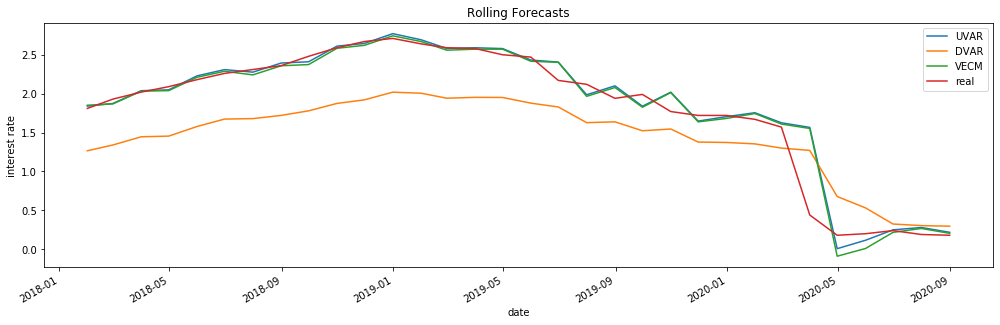

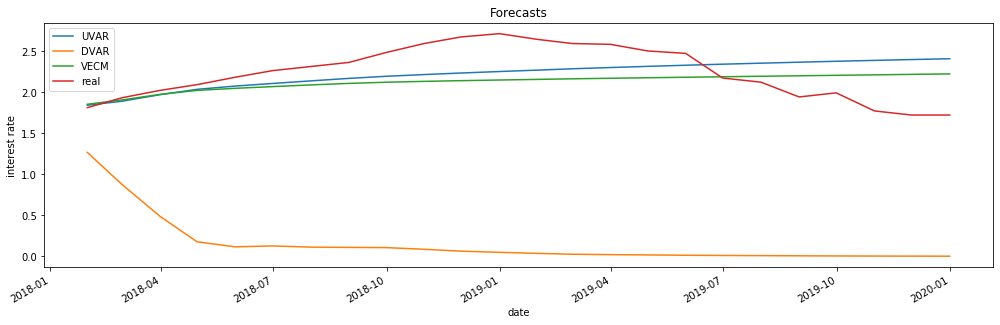

In [69]:
pd.DataFrame(np.concatenate([[rolling_fc1.fc],[rolling_fc2.fc],[rolling_fc3.fc],[rolling_fc1.real]]).T,
             index=time_out, columns=['UVAR','DVAR','VECM','real']).plot(title='Rolling Forecasts', figsize=(17,5)) .set(xlabel="date", ylabel="interest rate")
plt.savefig(fname='/Users/ezravanderstelt/Desktop/python/ectri/cointegration/graphs/forecasts.png')

h=24
pd.DataFrame(np.concatenate([[fc1.fc],[fc2.fc],[fc3.fc],[fc1.real]]).T,
             index=time_out[:h], columns=['UVAR','DVAR','VECM','real']).plot(title='Forecasts', figsize=(17,5)) .set(xlabel="date", ylabel="interest rate")

The VECM and UVAR are the best models for forecastng this dataset. The UVAR is best in terms of rolling forecasts and the VECM is slightly better in the long run forecasts. The DVAR performs much worse on all fronts.

## 5. Sources

- Bradley, M. & Lumpkin, S. (1992) The Treasury yield curve as a cointegrated system. J. Financial Quantitative Analysis 27, 449–463.
- Brooks, C. (2008) RATS handbook to accompany introductory econometrics for finance. Cambridge University Press, pp213. ISBN 9780521721684
- Christofferson, P. F., and F. X. Diebold, ‘‘Cointegration and Long-Horizon Forecasting,’’ Journal of Business and Economic Statistics 16 (1998), 450–458.
- Clements, M.P., Hendry, D.F., 1995. Forecasting in cointegrated systems. Journal of Applied Econometrics 10, 127–146.
- Engle, R. F. and Granger, C. W. J. (1987) Co-Integration and Error Correction: Representation, Estimation and Testing, Econometrica 55, 251--76
- Granger, C. W. J., and A. A. Weiss (1983): "Time Series Analysis of Error-Correcting Models," in Studies in Econometrics, Time Series, and Multivariate Statistics. New York: Academic Press, 255-278.
- Harris, R. (1995) Cointegration Analysis in Econometric Modelling, Prentice-Hall, Harlow, UK
- Hoffman, D.L., Rasche, R.H., 1996. Assessing forecast performance in a cointegrated system. Journal of Applied Econometrics 11, 495–517.
- Johansen S. (1995). Likelihood-Based Inference in Cointegrated Vector Autoregressive Models. Oxford University Press: Oxford.
- Sims, Christopher A. "Macroeconomics and Reality." Econometrica 48 (1980a), 1-48."Comparison of Interwar and Postwar Business Cycles: Monetarism Reconsidered." American Economic Review 70 (1980b), 250-57.

**TODO:** 
- structural analysis, impulse response functions and their confidence bounds p.51
- test for structural change (chow test) p.182

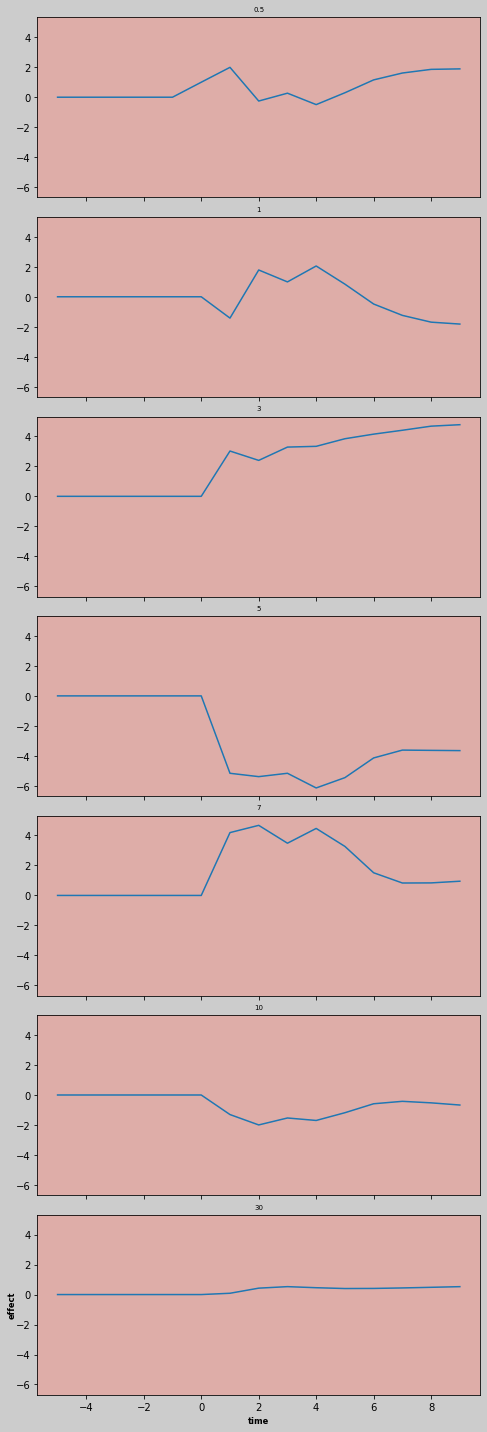

In [18]:
def IRF(colindex, data, coefs, p, magn=1, h=5):
    """Compute irf of col on system (Txk) for a certain number of periods.
    Unit shock in col at time 0"""
    k=coefs[0].shape[0]
    shock = np.zeros((1,k))
    shock[:,colindex] = magn    
    A=np.concatenate(coefs[1:], axis=0)
    phis = MA_Phi(coefs=A, p=p, h=h)
    
    irf = np.zeros((h,k))
    for step in range(h):
        pulse = shock@phis[step]
        irf[step] = pulse
    
    return irf

h=10    
impulse_col_index = 0
irf = IRF(impulse_col_index ,data,coefs,p,h=h)

pre = np.zeros((round(h/2),k))
irf = np.vstack([pre,irf])
timetime = list(range(-round(h/2),h))

fig,ax =  plt.subplots(k, figsize=(7,20), sharex=True, sharey=True)
plt.xlabel("time", size='small', weight='semibold')
plt.ylabel("effect", size='small', va='center', weight='semibold')
fig.patch.set_facecolor('grey')
fig.patch.set_alpha(0.4)
for i,col in enumerate(cols):
    ax[i].plot(timetime, irf[:,i])
    ax[i].set_title(col, fontsize = 7)
    ax[i].set_facecolor('salmon')
    ax[i].patch.set_alpha(0.4)
fig.tight_layout(h_pad = 0.5) 
# https://stackoverflow.com/questions/14088687/how-to-change-plot-background-color